In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

In [2]:
data = pd.read_csv("Clean_UoB_Set01_2025-01-02tapes.csv")

In [3]:
data.head()

,Time,Weighted_Price,Total_Size,Order_Number
0,10.881,267.0,1.0,1.0
1,11.067,269.0,1.0,1.0
2,11.222,267.0,2.0,1.0
3,12.338,270.0,2.0,1.0
4,13.733,267.0,3.0,1.0


In [4]:
data_copy = data[['Time','Weighted_Price']].copy()

In [5]:
data_copy

,Time,Weighted_Price
0,10.881,267.000000
1,11.067,269.000000
2,11.222,267.000000
3,12.338,270.000000
4,13.733,267.000000
...,...,...
18570,30594.830,285.333333
18571,30596.225,286.000000
18572,30598.085,287.500000
18573,30599.108,292.000000


In [6]:
max_time = data_copy['Time'].max()
min_time = data_copy['Time'].min()

# Calculate the correct range of bins, ensuring that we include the maximum time
# Add 10 to max_time to create a bin that includes the last data point if it falls exactly on a 10-second mark
time_bins = range(int(min_time) - (int(min_time) % 5), int(max_time) + 5, 5)

# Now we'll bin the data again using the corrected time bins
data_copy['time_bin'] = pd.cut(data_copy['Time'], bins=time_bins, right=False)

# Calculate the counts for each bin
corrected_bin_counts = data_copy['time_bin'].value_counts().sort_index()

# Converting the bin counts to a more readable string format
readable_corrected_bin_counts = corrected_bin_counts.rename(lambda x: f"{int(x.left)}-{int(x.right)}")
readable_corrected_bin_counts

time_bin
10-15          5
15-20          2
20-25          6
25-30          2
30-35          0
              ..
30575-30580    2
30580-30585    3
30585-30590    6
30590-30595    3
30595-30600    4
Name: count, Length: 6118, dtype: int64

In [7]:
def resample_and_adjust_using_original_times(df, target_count):
    # Creating a new column 'Time_bin' to convert 'Time' values into 10-second bins
    df['Time_bin'] = (df['Time'] // 5 * 5).astype(int)
    
    all_time_bins = range(df['Time_bin'].min(), df['Time_bin'].max() + 5, 5)
    grouped = df.groupby('Time_bin')

    new_records = []
    last_known_price = None 
    
    # Iterating through all possible time bins
    for time_bin in all_time_bins:
        # If the current time bin exists within the grouped data
        if time_bin in grouped.groups:
            group = grouped.get_group(time_bin)
            times = group['Time'].values
            prices = group['Weighted_Price'].values
            # If the prices array is not empty, update the last known price
            if len(prices) > 0:
                last_known_price = prices[-1]
        else:
            group = None 
            
        # If the current time bin is empty or has only one price data point
        if group is None or len(prices) == 0:
            prices = np.full(target_count, last_known_price)
            times = np.linspace(time_bin, time_bin + 4, num=target_count)
        elif len(prices) == 1:
            times = np.linspace(time_bin, time_bin + 4, num=target_count)
            prices = np.full(target_count, last_known_price)
        else:
            # If there are fewer data points than the target count, additional points will be added
            while len(prices) < target_count:
                time_diffs = np.diff(times)
                idx_to_fill = np.argmax(time_diffs)
                new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                times = np.insert(times, idx_to_fill + 1, new_time)
                prices = np.insert(prices, idx_to_fill + 1, new_price)
            # If there are multiple data points within the time bin, proceed with normal processing
            while len(prices) > target_count:
                time_diffs = np.diff(times)
                idx_to_merge = np.argmin(time_diffs)
                new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                times = np.insert(times, idx_to_merge, new_time)
                prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                prices = np.insert(prices, idx_to_merge, new_price)
         # Add the processed data to the results list          
        new_records.extend(zip(times, prices))

    new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
    new_df.sort_values('Time', inplace=True)
    return new_df

processed_df = resample_and_adjust_using_original_times(data_copy, 3)

In [8]:
processed_df

,Time,Weighted_Price
0,11.01275,267.500000
1,12.33800,270.000000
2,13.73300,267.000000
3,18.32100,265.000000
4,18.98750,264.333333
...,...,...
18349,30591.29600,288.250000
18350,30594.83000,285.333333
18351,30596.22500,286.000000
18352,30598.08500,287.500000


In [9]:
price = processed_df['Weighted_Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price)

In [10]:
def create_dataset(data, time_step, step=3):
    X, y = [], []
    for i in range(0, len(data)-time_step, step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[(i+time_step):(i+time_step+3), 0])
    return np.array(X), np.array(y)

In [11]:
time_step = 360

In [12]:
X, y = create_dataset(scaled_data, time_step)

In [13]:
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], y.shape[1], 1)

In [14]:
total_len = len(X)
train_ratio = 0.6

non_train_ratio = 0.4
valid_test_ratio = 0.5 

train_index = int(train_ratio * total_len)
non_train_index = int(non_train_ratio * total_len / 2)

X_train = X[:train_index]
y_train = y[:train_index]

X_valid = X[train_index:train_index + non_train_index]
y_valid = y[train_index:train_index + non_train_index]

X_test = X[train_index + non_train_index:]
y_test = y[train_index + non_train_index:]

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dense(units=3))

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 0.1455 - val_loss: 0.0056
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11

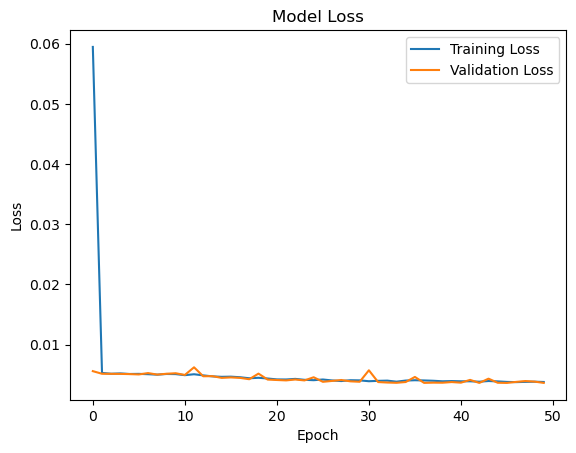

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Add label for training loss plot
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add label for validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # This line creates the legend based on the provided labels
plt.title('Model Loss')  # Set the title of the plot
plt.show()

In [19]:
processed_df['Time'] = pd.to_datetime(processed_df['Time'], unit='s')
processed_df.set_index('Time',inplace=True)

In [20]:
predictions = []
all_results = pd.DataFrame()
for i in range(0, len(X_test)):
    X_batch = np.expand_dims(X_test[i], axis=0)
    forecast_values = model.predict(X_batch)
    forecast_values = scaler.inverse_transform(forecast_values)
    forecast_values = forecast_values.flatten()
    forecast_index = processed_df[3*(train_index+non_train_index+i)+time_step:3*(train_index+non_train_index+i)+time_step+3].index
    forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['Forecasted_Price'])
    df = pd.DataFrame(X_test[i], columns=['Price'])
    price_changes = df['Price'].pct_change()
    volatility = np.std(price_changes)
    multiplier = 1
    threshold = volatility * multiplier
    max_price = forecast_df['Forecasted_Price'].max()
    min_price = forecast_df['Forecasted_Price'].min()
    max_time = forecast_df['Forecasted_Price'].idxmax()
    min_time = forecast_df['Forecasted_Price'].idxmin()
    max_time = pd.to_datetime(max_time)
    min_time = pd.to_datetime(min_time)
    
    decision = 1 if min_time < max_time else 2
    act_buy = False if min_price <  (1-threshold)*processed_df.loc[min_time]['Weighted_Price']  else True
    act_sell = False if max_price >  (1+threshold)*processed_df.loc[max_time]['Weighted_Price'] else True
    result = pd.DataFrame({
    'Highest_Price': [max_price],  
    'Lowest_Price': [min_price],
    'Threshold':threshold ,
    'Decision': [decision],
    'act_buy': [act_buy],
    'act_sell': [act_sell]
}, index=[max_time])  
    all_results = pd.concat([all_results, result])
    predictions.extend(forecast_values)  

predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [21]:
rmse = np.sqrt(mean_squared_error(processed_df[3*(train_index + non_train_index)+time_step:], predictions))
print('Root Mean Squared Error:', rmse)
from sklearn.metrics import r2_score
r_squared = r2_score(processed_df[3*(train_index + non_train_index)+time_step:], predictions)
print('R² Score:', r_squared)

Root Mean Squared Error: 3.672437998391096
R² Score: 0.501941046482709


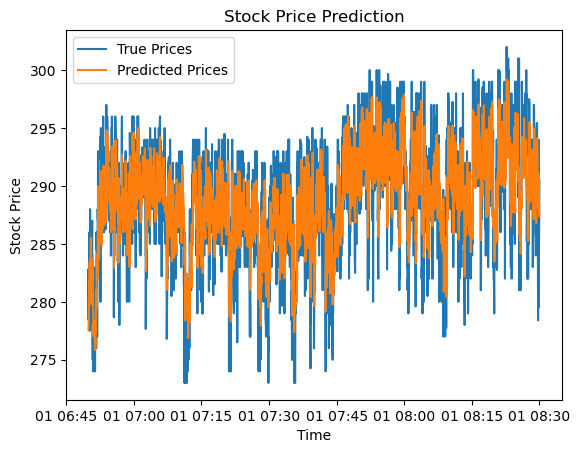

In [22]:
plt.plot(processed_df[3*(train_index + non_train_index)+time_step:].index, processed_df[3*(train_index + non_train_index)+time_step:], label='True Prices')
plt.plot(processed_df[3*(train_index + non_train_index)+time_step:].index, predictions, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
all_results

,Highest_Price,Lowest_Price,Threshold,Decision,act_buy,act_sell
1970-01-01 06:49:58.593000,278.058136,277.605438,0.065490,1,True,True
1970-01-01 06:50:00.608000,279.935028,279.545898,0.066196,2,True,True
1970-01-01 06:50:06.901000,281.794891,280.795410,0.066301,2,True,True
1970-01-01 06:50:11.303000,283.401733,282.057465,0.066553,2,True,True
1970-01-01 06:50:17.224000,283.637909,282.186401,0.067533,2,True,True
...,...,...,...,...,...,...
1970-01-01 08:29:37.005000,289.635315,288.779663,0.066833,2,True,True
1970-01-01 08:29:42.151000,288.570557,288.033203,0.066218,2,True,True
1970-01-01 08:29:45.731500,291.087585,289.658722,0.068480,2,True,True
1970-01-01 08:29:50.242000,288.042542,287.727356,0.068858,2,True,True


In [24]:
initial_capital = 10000
transaction_num = 1
hold_stocks = False
transaction_result = []
stock_num = 0


for index, row in all_results.iterrows():
    operation = row['Decision']
    highest_price = row['Highest_Price']
    lowest_price = row['Lowest_Price']
    act_buy = row['act_buy']
    act_sell = row['act_sell']
    
    if highest_price-lowest_price >= 1 and operation == 1:
        
        if  act_buy == True and act_sell == True  and initial_capital >= highest_price:

            initial_capital -= transaction_num * lowest_price
            stock_num += transaction_num
            initial_capital += stock_num*highest_price
            sell_num = stock_num
            stock_num = 0
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'buy first and sell all', 'buy price':lowest_price,'sell price':highest_price ,'sell number':sell_num ,'buy_num':transaction_num})

        if  act_buy == False and act_sell == True   and hold_stocks == True :

            initial_capital += stock_num*highest_price
            sell_num = stock_num
            stock_num = 0
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'buy faild only sell', 'buy price': 0,'sell price': highest_price,'sell number':sell_num ,'buy_num': 0 })

        if  act_buy == False and act_sell == True  and initial_capital >= highest_price :
            initial_capital -= transaction_num * lowest_price
            stock_num += transaction_num
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'sell faild only buy', 'buy price':lowest_price ,'sell price': 0,'sell number':0 ,'buy_num': transaction_num })

        if  act_buy == False and act_sell == False:
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'sell faild and buy faild', 'buy price':0 ,'sell price': 0,'sell number':0 ,'buy_num': 0 })

if hold_stocks == True:
    final_price = data_copy['Weighted_Price'].iloc[-1]
    initial_capital += final_price*stock_num
    sell_num = stock_num
    stock_num = 0
    hold_stocks = False
    transaction_result.append({'operation': 'sell all', 'buy price':final_price ,'sell price': 0,'sell number':sell_num ,'buy_num': stock_num })
    
transaction_result_df = pd.DataFrame(transaction_result)
print(transaction_result_df)

# Calculate final capital and profit
final_capital = initial_capital
profit = final_capital - 10000
profitability = profit/10000
profitability_percent = "{:.4f}%".format(profitability * 100)
print(f'capital at closing：{final_capital}')
print(f'total_profit：{profit}')
print(f'Profitability：{profitability_percent}')

# profitability_data = {
#     'Final Capital': final_capital,
#     'Profit': profit,
#     'Profitability': profitability,
#     'Profitability Percent': profitability_percent
# }

#     # Convert the dictionary to a DataFrame
# profitability_df = pd.DataFrame([profitability_data])

    
# if match:
#     date_string = match.group(0)
#     new_file_name = f'{date_string}_transaction_result.csv'
#     new_file_name1 = f'{date_string}_profitability.csv'
#     transaction_result_df.to_csv(os.path.join(output_folder, new_file_name))
#     profitability_df.to_csv(os.path.join(output_folder, new_file_name1))

                 operation   buy price  sell price  sell number  buy_num
0   buy first and sell all  282.950989  284.127625            1        1
1   buy first and sell all  282.655548  283.927216            1        1
2   buy first and sell all  281.045166  282.331146            1        1
3   buy first and sell all  278.400452  279.995026            1        1
4   buy first and sell all  279.480774  281.164429            1        1
5   buy first and sell all  278.737061  280.320435            1        1
6   buy first and sell all  278.290314  279.359589            1        1
7   buy first and sell all  281.043152  282.084717            1        1
8   buy first and sell all  280.204865  281.413788            1        1
9   buy first and sell all  279.563690  280.794220            1        1
10  buy first and sell all  278.798431  279.935455            1        1
11  buy first and sell all  277.376740  278.664795            1        1
12  buy first and sell all  280.409271  281.684723 